In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.619386,0.973682,00:00
1,0.846683,0.665450,00:00
2,0.648963,0.655851,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [11]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2019-06-16 14:35:04--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.93MB/s    in 1.6s    

2019-06-16 14:35:06 (2.93 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [0]:
!mv ./ml-100k.zip ~/.fastai/data/

In [0]:
import zipfile
fp=zipfile.ZipFile('/root/.fastai/data/ml-100k.zip')
fp.extractall('/root/.fastai/data')

In [0]:
path=Config.data_path()/'ml-100k'

In [29]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [31]:
len(ratings)

100000

In [32]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [34]:
data.show_batch()

userId,title,target
648,Mighty Aphrodite (1995),3.0
457,"Postino, Il (1994)",4.0
655,Walking and Talking (1996),3.0
222,Aladdin (1992),4.0
537,"Good, The Bad and The Ugly, The (1966)",3.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


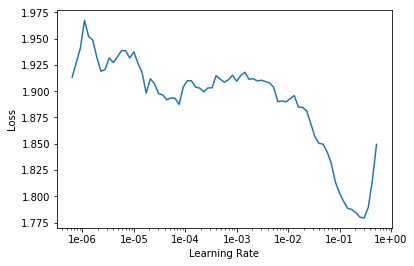

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [37]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.935275,0.949416,00:09
1,0.863663,0.884337,00:08
2,0.762157,0.839347,00:08
3,0.654652,0.815229,00:08
4,0.571526,0.814104,00:08


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [40]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [41]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [42]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [45]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3759),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3332),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3026), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2617), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2545), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2288), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2275), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2227), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2197), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2175), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2161), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2147), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2122), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2072), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2049), 'Free Willy 3: The Rescue (1

In [46]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6027), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5648), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5488), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5463), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5431), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5384), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5331), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5016), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4989), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4968), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4878), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4822), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4757), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4717), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4669), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667)]

### Movie weights

In [47]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [48]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0498), 'Close Shave, A (1995)'),
 (tensor(1.0427), 'Lawrence of Arabia (1962)'),
 (tensor(1.0392), 'Apocalypse Now (1979)'),
 (tensor(1.0352), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(1.0324), 'Wrong Trousers, The (1993)'),
 (tensor(1.0230), 'Godfather, The (1972)'),
 (tensor(1.0180), 'Casablanca (1942)'),
 (tensor(0.9733),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9593), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9585), 'Chinatown (1974)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2868), 'Home Alone 3 (1997)'),
 (tensor(-1.2448), 'Jungle2Jungle (1997)'),
 (tensor(-1.1555), "McHale's Navy (1997)"),
 (tensor(-1.1471), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1290), 'Leave It to Beaver (1997)'),
 (tensor(-1.1144), 'Flipper (1996)'),
 (tensor(-1.1115), 'Congo (1995)'),
 (tensor(-1.0987), 'Bio-Dome (1996)'),
 (tensor(-1.0936), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0376), 'Mortal Kombat: Annihilation (1997)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1540), 'Braveheart (1995)'),
 (tensor(1.0953), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0868), 'Titanic (1997)'),
 (tensor(0.9410), "It's a Wonderful Life (1946)"),
 (tensor(0.8886), 'Star Wars (1977)'),
 (tensor(0.8825), 'Independence Day (ID4) (1996)'),
 (tensor(0.8703), 'Pretty Woman (1990)'),
 (tensor(0.8571), 'Forrest Gump (1994)'),
 (tensor(0.8533), 'Top Gun (1986)'),
 (tensor(0.8301), 'Return of the Jedi (1983)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8212), 'Keys to Tulsa (1997)'),
 (tensor(-0.8137), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8051), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7698), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7566), 'Brazil (1985)'),
 (tensor(-0.7471), 'Cable Guy, The (1996)'),
 (tensor(-0.7336), 'Trainspotting (1996)'),
 (tensor(-0.7243), 'Stupids, The (1996)'),
 (tensor(-0.7231), 'Jude (1996)'),
 (tensor(-0.7178), 'Big Night (1996)')]

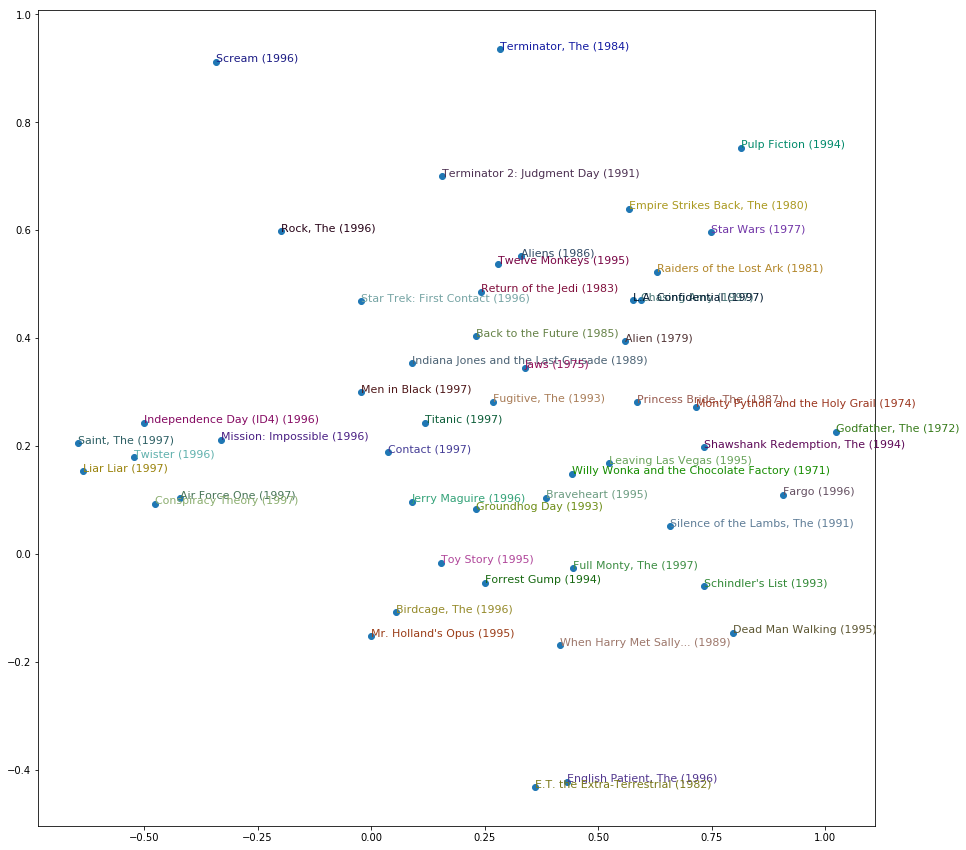

In [55]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()